In [1]:
import math
import matplotlib.pyplot as plt
import scipy
import cv2
import numpy as np
import glob
import os
import pandas as pd
import tensorflow as tf
import itertools
import random
from random import shuffle
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [3]:
train_dir=Path('training/training/')
test_dir=Path('validation/validation/')

In [4]:
cols=['Label','Latin Name','Common Name','Train Images','Validation Images']
labels=pd.read_csv("monkey_labels.txt",names=cols,skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [5]:
labels=labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [6]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir=Path('training/training/'+label)
        imgfile=random.choice(os.listdir(imgdir))
        img=cv2.imread('training/training/'+label+'/'+imgfile)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

 pygmy_marmoset                


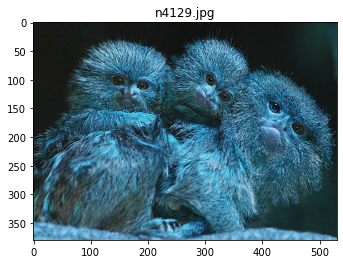

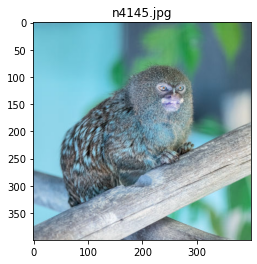

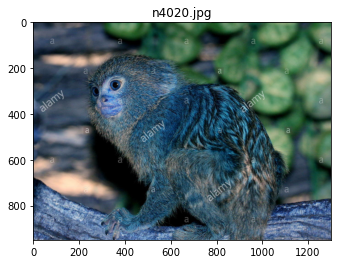

In [7]:
print(labels[4])
image_show(3,'n4')

In [8]:
LR=1e-3
height=15
width=150
channels=3
seed=1337
batch_size=64
num_classes=10
epochs=200
data_augmentation=True
num_predictions=20
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator=train_datagen.flow_from_directory(train_dir,
target_size=(height,width),
batch_size=batch_size,
seed=seed,
shuffle=True,
class_mode='categorical',
)
test_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=test_datagen.flow_from_directory(test_dir,
target_size=(height,width),
batch_size=batch_size,
seed=seed,
shuffle=False,
class_mode='categorical')
train_num=train_generator.samples
validation_num=validation_generator.samples

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [9]:
# model=Sequential()
# model.add(Conv2D(32,(3,3),input_shape=(150,150,3),strides=2))
# model.add(Activation('relu'))

# model.add(BatchNormalization())
# model.add(Conv2D(32,(3,3),strides=2))
# model.add(Activation('relu'))

# model.add(BatchNormalization())
# model.add(Conv2D(64,(3,3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64,(3,3),strides=2))
# model.add(Activation('relu'))

# model.add(Conv2D(512,(1,1),strides=2))
# model.add(Activation('relu'))
# model.add(Conv2D(num_classes,(1,1)))
# model.add(GlobalAvgPool2D())
# model.add(Activation('softmax'))


model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(150,150,3),strides=2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [10]:
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 74, 74, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 35, 35, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        1

In [11]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint=ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
callbacks_list=[checkpoint]

In [12]:
history=model.fit_generator(train_generator,
                            steps_per_epoch=train_num//batch_size,
                            epochs=epochs,
                            validation_data=train_generator,
                            validation_steps=validation_num//batch_size,
                            callbacks=callbacks_list,
                            verbose=1
                            )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200


In [ ]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.title('Training and Validation Accuracy')
plt.plot(epochs,acc,'red',label='Training Accuracy')
plt.plot(epochs,val_loss,'blue',label='Validation Loss')

plt.legend()

plt.show()

Error: Session cannot generate requests

In [ ]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

In [ ]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))

In [ ]:
test_list = os.listdir("../input/test-monkeys/")
test_list.sort()
print(test_list)
model_test = load_model(filepath)